In [1]:
"""
Link Prediction using Graph Neural Networks

"""
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import dgl.data
import pandas as pd
from dgl import graph
from dgl.nn import SAGEConv
import dgl.function as fn
import math
from sklearn.metrics import roc_auc_score

/Users/amohammadi/GNN_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Closest / Working

In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import pandas as pd
from dgl import graph
from dgl.nn import SAGEConv
import dgl.function as fn
import math
from sklearn.metrics import roc_auc_score

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

def compute_acc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).cpu().numpy()
    scores = [1 if i >= 0.5 else 0 for i in scores]
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).cpu().numpy()
    correct_pred = 0
    for i in range(labels.shape[0]):
        if labels[i] == scores[i]:
            correct_pred += 1
    return correct_pred / labels.shape[0]



datasets = ['algo004', 'ml', 'comp', 'virtualshakespeare']
for ds in datasets:
    data_total = pd.read_csv('data/w_removal_%s' % ds, sep=" ", header=None)
    print('Analyzing %s Dataset' % ds)
    data_total.columns = ["n1", "n2", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "l"]
    data_total.dropna(subset=['n1', 'n2'], inplace=True)

    # taking the unique values of the nodes and saving the indices
    nodes = np.unique(data_total[['n1', 'n2']].values)
    node_index = {node: idx for idx, node in enumerate(nodes)}

    # creating an adj matrix (numpy) of size nodes*nodes filled with 0s
    adj_matrix = np.zeros((len(nodes), len(nodes)), dtype=float)

    # populating the adj matrix using the nodes and the labels
    for _, row in data_total.iterrows():
        i, j = node_index[row['n1']], node_index[row['n2']]
        adj_matrix[i, j] = row['l']
        adj_matrix[j, i] = row['l']

    # turning the numpy matrix into a pandas df
    adj_df = pd.DataFrame(adj_matrix, index=nodes, columns=nodes)

    labels = data_total["l"]
    ones_label = np.where(labels == 1)

    # Create graph using node indices
    src = data_total["n1"].map(node_index).astype(int)
    dst = data_total["n2"].map(node_index).astype(int)

    src = torch.tensor(src.values[ones_label], dtype=torch.int64).to(device)
    dst = torch.tensor(dst.values[ones_label], dtype=torch.int64).to(device)

    """g = dgl.graph((src, dst))

    # Initialize node features as an identity matrix
    inputs = torch.eye(g.number_of_nodes()).to(device)"""

    g = graph((torch.cat([src, dst]), torch.cat([dst, src])))
    g = g.to(device)
    inputs = g.adj().to_dense().to(device)    

    """
    Generate all of the possible edges and remove 90% of them from the training set
    """
    upper_tri_idx = np.triu_indices_from(adj_df, k=1)
    pairs = [(i, j) for i, j in zip(*upper_tri_idx)]
    pairs += [(j, i) for i, j in pairs]  # Add (j, i) for each (i, j)
    
    np.random.shuffle(pairs)
    possible_edges = np.array(pairs)
    
    test_size = int(len(possible_edges) * 0.05)
    train_size = len(possible_edges) - test_size
    
    test_edges = possible_edges[:test_size]
    train_edges = possible_edges[test_size:]

    test_pos_u = []
    test_pos_v = []
    test_neg_u = []
    test_neg_v = []

    for u, v in test_edges:
        if g.has_edges_between(u, v):
            test_pos_u.append(u)
            test_pos_v.append(v)
        else:
            test_neg_u.append(u)
            test_neg_v.append(v)

    train_pos_u = []
    train_pos_v = []
    train_neg_u = []
    train_neg_v = []
    
    for u, v in train_edges:
        if g.has_edges_between(u, v):
            train_pos_u.append(u)
            train_pos_v.append(v)
        else:
            train_neg_u.append(u)
            train_neg_v.append(v)
            
    #train_u, train_v = train_edges[:, 0], train_edges[:, 1]

    # Create subgraphs for training and testing
    train_pos_g = dgl.graph((torch.tensor(train_pos_u), torch.tensor(train_pos_v)), num_nodes=g.number_of_nodes()).to(device)
    train_neg_g = dgl.graph((torch.tensor(train_neg_u), torch.tensor(train_neg_v)), num_nodes=g.number_of_nodes()).to(device)

    test_pos_g = dgl.graph((torch.tensor(test_pos_u), torch.tensor(test_pos_v)), num_nodes=g.number_of_nodes()).to(device)
    test_neg_g = dgl.graph((torch.tensor(test_neg_u), torch.tensor(test_neg_v)), num_nodes=g.number_of_nodes()).to(device)

    print(f'Number of nodes and edges in train_pos_g: {len(train_pos_g.nodes())} , {len(train_pos_g.edges()[0])}')
    print(f'Number of nodes and edges in train_neg_g: {len(train_neg_g.nodes())} , {len(train_neg_g.edges()[0])}')
    print(f'Number of nodes and edges in test_pos_g: {len(test_pos_g.nodes())} , {len(test_pos_g.edges()[0])}')
    print(f'Number of nodes and edges in test_neg_g: {len(test_neg_g.nodes())} , {len(test_neg_g.edges()[0])}')
    
    model = GraphSAGE(g.number_of_nodes(), 16).to(device)
    pred = DotPredictor().to(device)

    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.001)

    for e in range(501):
        h = model(train_pos_g, inputs)
        pos_score = pred(train_pos_g, h)
        neg_score = pred(train_neg_g, h)
        loss = compute_loss(pos_score, neg_score)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 100 == 0:
            print('In epoch {}, loss: {}'.format(e, loss.item()))

    with torch.no_grad():
        h = model(train_pos_g, inputs)
        pos_score = pred(test_pos_g, h)
        neg_score = pred(test_neg_g, h)
        print('AUC', compute_auc(pos_score, neg_score))
        print('ACC', compute_acc(pos_score, neg_score))


# With loop for percentage

In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import pandas as pd
from dgl import graph
from dgl.nn import SAGEConv
import dgl.function as fn
import math
from sklearn.metrics import roc_auc_score

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

def compute_acc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).cpu().numpy()
    scores = [1 if i >= 0.5 else 0 for i in scores]
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).cpu().numpy()
    correct_pred = 0
    for i in range(labels.shape[0]):
        if labels[i] == scores[i]:
            correct_pred += 1
    return correct_pred / labels.shape[0]

results = []

datasets = ['algo004', 'ml', 'comp', 'virtualshakespeare']
test_sizes = [0.05, 0.1, 0.15, 0.2, 0.25]

for ds in datasets:
    data_total = pd.read_csv('data/w_removal_%s' % ds, sep=" ", header=None)
    print('Analyzing %s Dataset' % ds)
    data_total.columns = ["n1", "n2", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "l"]
    data_total.dropna(subset=['n1', 'n2'], inplace=True)

    # taking the unique values of the nodes and saving the indices
    nodes = np.unique(data_total[['n1', 'n2']].values)
    node_index = {node: idx for idx, node in enumerate(nodes)}

    # creating an adj matrix (numpy) of size nodes*nodes filled with 0s
    adj_matrix = np.zeros((len(nodes), len(nodes)), dtype=float)

    # populating the adj matrix using the nodes and the labels
    for _, row in data_total.iterrows():
        i, j = node_index[row['n1']], node_index[row['n2']]
        adj_matrix[i, j] = row['l']
        adj_matrix[j, i] = row['l']

    # turning the numpy matrix into a pandas df
    adj_df = pd.DataFrame(adj_matrix, index=nodes, columns=nodes)

    labels = data_total["l"]
    ones_label = np.where(labels == 1)

    # Create graph using node indices
    src = data_total["n1"].map(node_index).astype(int)
    dst = data_total["n2"].map(node_index).astype(int)

    src = torch.tensor(src.values[ones_label], dtype=torch.int64).to(device)
    dst = torch.tensor(dst.values[ones_label], dtype=torch.int64).to(device)

    g = graph((torch.cat([src, dst]), torch.cat([dst, src])))
    g = g.to(device)
    inputs = g.adj().to_dense().to(device)    

    for test_size in test_sizes:
        print(f'Test size: {test_size}')
        """
        Generate all of the possible edges and remove 90% of them from the training set
        """
        upper_tri_idx = np.triu_indices_from(adj_df, k=1)
        pairs = [(i, j) for i, j in zip(*upper_tri_idx)]
        pairs += [(j, i) for i, j in pairs]  # Add (j, i) for each (i, j)
        
        np.random.shuffle(pairs)
        possible_edges = np.array(pairs)
        
        test_size = int(len(possible_edges) * test_size)
        train_size = len(possible_edges) - test_size
        
        test_edges = possible_edges[:test_size]
        train_edges = possible_edges[test_size:]

        test_pos_u = []
        test_pos_v = []
        test_neg_u = []
        test_neg_v = []

        for u, v in test_edges:
            if g.has_edges_between(u, v):
                test_pos_u.append(u)
                test_pos_v.append(v)
            else:
                test_neg_u.append(u)
                test_neg_v.append(v)

        train_pos_u = []
        train_pos_v = []
        train_neg_u = []
        train_neg_v = []
        
        for u, v in train_edges:
            if g.has_edges_between(u, v):
                train_pos_u.append(u)
                train_pos_v.append(v)
            else:
                train_neg_u.append(u)
                train_neg_v.append(v)
                
        # Create subgraphs for training and testing
        train_pos_g = dgl.graph((torch.tensor(train_pos_u), torch.tensor(train_pos_v)), num_nodes=g.number_of_nodes()).to(device)
        train_neg_g = dgl.graph((torch.tensor(train_neg_u), torch.tensor(train_neg_v)), num_nodes=g.number_of_nodes()).to(device)

        test_pos_g = dgl.graph((torch.tensor(test_pos_u), torch.tensor(test_pos_v)), num_nodes=g.number_of_nodes()).to(device)
        test_neg_g = dgl.graph((torch.tensor(test_neg_u), torch.tensor(test_neg_v)), num_nodes=g.number_of_nodes()).to(device)

        print(f'Number of nodes and edges in train_pos_g: {len(train_pos_g.nodes())} , {len(train_pos_g.edges()[0])}')
        print(f'Number of nodes and edges in train_neg_g: {len(train_neg_g.nodes())} , {len(train_neg_g.edges()[0])}')
        print(f'Number of nodes and edges in test_pos_g: {len(test_pos_g.nodes())} , {len(test_pos_g.edges()[0])}')
        print(f'Number of nodes and edges in test_neg_g: {len(test_neg_g.nodes())} , {len(test_neg_g.edges()[0])}')
        
        model = GraphSAGE(g.number_of_nodes(), 16).to(device)
        pred = DotPredictor().to(device)

        optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.001)

        for e in range(501):
            h = model(train_pos_g, inputs)
            pos_score = pred(train_pos_g, h)
            neg_score = pred(train_neg_g, h)
            loss = compute_loss(pos_score, neg_score)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if e % 100 == 0:
                print('In epoch {}, loss: {}'.format(e, loss.item()))

        with torch.no_grad():
            h = model(train_pos_g, inputs)
            pos_score = pred(test_pos_g, h)
            neg_score = pred(test_neg_g, h)
            print('AUC', compute_auc(pos_score, neg_score))
            print('ACC', compute_acc(pos_score, neg_score))

        


/Users/amohammadi/GNN_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Analyzing algo004 Dataset
Test size: 0.05
Number of nodes and edges in train_pos_g: 1165 , 12857
Number of nodes and edges in train_neg_g: 1165 , 1275400
Number of nodes and edges in test_pos_g: 1165 , 689
Number of nodes and edges in test_neg_g: 1165 , 67114
In epoch 0, loss: 1.1400586366653442
In epoch 100, loss: 0.6855957508087158
In epoch 200, loss: 0.6709774136543274
In epoch 300, loss: 0.6522641181945801
In epoch 400, loss: 0.6355752348899841
In epoch 500, loss: 0.6226822733879089
AUC 0.7750189191338888
ACC 0.9841452443107237


NameError: name 'auc' is not defined

# Creating the 4 graphs for algo004 and comp datasets then combining

In [3]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import pandas as pd
from dgl import graph
from dgl.nn import SAGEConv
import dgl.function as fn
import math
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import networkx as nx
import os
from joblib import Parallel, delayed


# Build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).cpu().numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).cpu().numpy()
    return roc_auc_score(labels, scores)

def compute_acc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).cpu().numpy()
    scores = [1 if i >= 0.5 else 0 for i in scores]
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).cpu().numpy()
    correct_pred = 0
    for i in range(labels.shape[0]):
        if labels[i] == scores[i]:
            correct_pred += 1
    return correct_pred / labels.shape[0]

/Users/amohammadi/GNN_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [112]:
def mean_algebraic_connectivity(nx_graph):
    # Get all connected components in the graph
    connected_components = [nx_graph.subgraph(c).copy() for c in nx.connected_components(nx_graph)]

    # Initialize list to store algebraic connectivity values
    connectivity_values = []

    # Loop through each connected component and calculate the algebraic connectivity
    for component in connected_components:
        if len(component) >= 5:  # Algebraic connectivity is only defined for graphs with more than 1 node
            connectivity = nx.algebraic_connectivity(component)
            connectivity_values.append(connectivity)
        else:
            print(f"Component with only 1 node: {list(component.nodes)}")

    # Calculate and return the mean algebraic connectivity
    if connectivity_values:
        mean_connectivity = sum(connectivity_values) / len(connectivity_values)
        return mean_connectivity
    else:
        return 0.0  # Return 0 if there are no valid connected components

In [113]:
G = nx.from_numpy_array(adj_matrix)
fiedler = mean_algebraic_connectivity(G)

Component with only 1 node: [6]
Component with only 1 node: [19]
Component with only 1 node: [32, 787]
Component with only 1 node: [35]
Component with only 1 node: [528, 39, 654, 183]
Component with only 1 node: [42, 238]
Component with only 1 node: [45]
Component with only 1 node: [51]
Component with only 1 node: [249, 67, 598]
Component with only 1 node: [74]
Component with only 1 node: [83]
Component with only 1 node: [592, 101, 439]
Component with only 1 node: [106]
Component with only 1 node: [112, 969]
Component with only 1 node: [118]
Component with only 1 node: [126, 758]
Component with only 1 node: [128, 1070]
Component with only 1 node: [134]
Component with only 1 node: [144]
Component with only 1 node: [157]
Component with only 1 node: [173]
Component with only 1 node: [346, 885, 309, 182]
Component with only 1 node: [189]
Component with only 1 node: [1092, 199]
Component with only 1 node: [216]
Component with only 1 node: [226, 949]
Component with only 1 node: [227]
Compone

In [114]:
fiedler

0.2650309698583493

In [154]:
connected_components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
temp = 0
temp2 = 0
for component in connected_components:
        if len(component) > 1:  # Algebraic connectivity is only defined for graphs with more than 1 node
            temp += 1
        else:
            temp2 += 1
print(temp)
print(temp2)

20
87


## Algo004 dataset

Analyzing algo004 Dataset
Fold 1 of 10
In epoch 0, loss: 1.2714616060256958
In epoch 100, loss: 0.6884055733680725
In epoch 200, loss: 0.676465630531311
In epoch 300, loss: 0.6645388007164001
In epoch 400, loss: 0.655613362789154
In epoch 500, loss: 0.6438919305801392
AUC 0.7595192411201703
ACC 0.9855463622553574
Fold 2 of 10
In epoch 0, loss: 1.6992290019989014
In epoch 100, loss: 0.6865578889846802
In epoch 200, loss: 0.6731442213058472
In epoch 300, loss: 0.6601445078849792
In epoch 400, loss: 0.6496444344520569
In epoch 500, loss: 0.639138400554657
AUC 0.7457902577990463
ACC 0.9843930209577747
Fold 3 of 10
In epoch 0, loss: 1.246417760848999
In epoch 100, loss: 0.688645601272583
In epoch 200, loss: 0.6716256141662598
In epoch 300, loss: 0.6524522304534912
In epoch 400, loss: 0.6404491662979126
In epoch 500, loss: 0.6289765238761902
AUC 0.7900909152602864
ACC 0.9845110098373229
Fold 4 of 10
In epoch 0, loss: 1.652479887008667
In epoch 100, loss: 0.6915237307548523
In epoch 200, loss

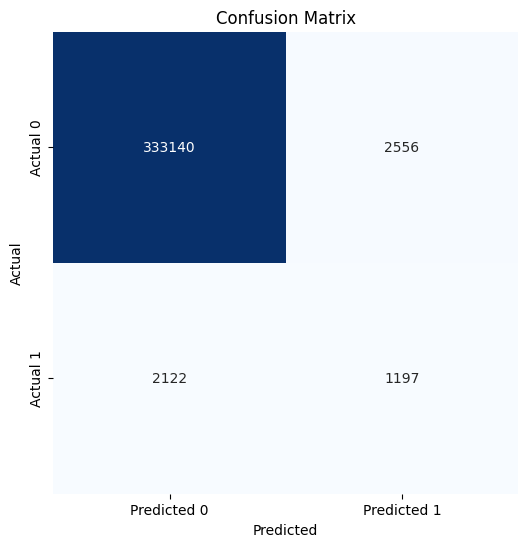

In [54]:
res = []
datasets = ['algo004']
for ds in datasets:
    data_total = pd.read_csv('data/w_removal_%s' % ds, sep=" ", header=None)
    print('Analyzing %s Dataset' % ds)
    data_total.columns = ["n1", "n2", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "l"]
    data_total.dropna(subset=['n1', 'n2'], inplace=True)

    # taking the unique values of the nodes and saving the indices
    nodes = np.unique(data_total[['n1', 'n2']].values)
    node_index = {node: idx for idx, node in enumerate(nodes)}

    # creating an adj matrix (numpy) of size nodes*nodes filled with 0s
    adj_matrix = np.zeros((len(nodes), len(nodes)), dtype=float)

    # populating the adj matrix using the nodes and the labels
    for _, row in data_total.iterrows():
        i, j = node_index[row['n1']], node_index[row['n2']]
        adj_matrix[i, j] = row['l']
        adj_matrix[j, i] = row['l']

    # turning the numpy matrix into a pandas df
    adj_df = pd.DataFrame(adj_matrix, index=nodes, columns=nodes)

    labels = data_total["l"]
    ones_label = np.where(labels == 1)

    # Create graph using node indices
    src = data_total["n1"].map(node_index).astype(int)
    dst = data_total["n2"].map(node_index).astype(int)

    src = torch.tensor(src.values[ones_label], dtype=torch.int64)
    dst = torch.tensor(dst.values[ones_label], dtype=torch.int64)

    """g = dgl.graph((src, dst))

    # Initialize node features as an identity matrix
    inputs = torch.eye(g.number_of_nodes()).to(device)"""

    algo_g = graph((torch.cat([src, dst]), torch.cat([dst, src])))
    algo_g = algo_g
    inputs_algo = algo_g.adj().to_dense()
    

    """
    Generate all of the possible edges and remove 90% of them from the training set
    """
    # K-fold cross validation
    k = 10
    auc_all = np.zeros((k,))
    acc_all = np.zeros((k,))

    for _ in range(k):
        print('Fold %d of %d' % (_+1, k))
    
        
        upper_tri_idx = np.triu_indices_from(adj_df, k=1)
        pairs = [(i, j) for i, j in zip(*upper_tri_idx)]
        pairs += [(j, i) for i, j in pairs]  # Add (j, i) for each (i, j)
        
        np.random.shuffle(pairs)
        possible_edges = np.array(pairs)
        
        test_size = int(len(possible_edges) * 0.25) # How much of the possible edges we will be removing
        train_size = len(possible_edges) - test_size
        
        test_edges = possible_edges[:test_size]
        train_edges = possible_edges[test_size:]
    
        test_pos_u = []
        test_pos_v = []
        test_neg_u = []
        test_neg_v = []
    
        for u, v in test_edges:
            if algo_g.has_edges_between(u, v):
                test_pos_u.append(u)
                test_pos_v.append(v)
            else:
                test_neg_u.append(u)
                test_neg_v.append(v)
    
        train_pos_u = []
        train_pos_v = []
        train_neg_u = []
        train_neg_v = []
        
        for u, v in train_edges:
            if algo_g.has_edges_between(u, v):
                train_pos_u.append(u)
                train_pos_v.append(v)
            else:
                train_neg_u.append(u)
                train_neg_v.append(v)
                
        #train_u, train_v = train_edges[:, 0], train_edges[:, 1]
    
        # Create subgraphs for training and testing
        train_pos_g_algo = dgl.graph((torch.tensor(train_pos_u), torch.tensor(train_pos_v)), num_nodes=algo_g.number_of_nodes())
        train_neg_g_algo = dgl.graph((torch.tensor(train_neg_u), torch.tensor(train_neg_v)), num_nodes=algo_g.number_of_nodes())
    
        test_pos_g_algo = dgl.graph((torch.tensor(test_pos_u), torch.tensor(test_pos_v)), num_nodes=algo_g.number_of_nodes())
        test_neg_g_algo = dgl.graph((torch.tensor(test_neg_u), torch.tensor(test_neg_v)), num_nodes=algo_g.number_of_nodes())
        
         
        model = GraphSAGE(algo_g.number_of_nodes(), 16)
        pred = DotPredictor()
        
        optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.001)
        
        for e in range(501):
            h = model(train_pos_g_algo, inputs_algo)
            pos_score = pred(train_pos_g_algo, h)
            neg_score = pred(train_neg_g_algo, h)
            loss = compute_loss(pos_score, neg_score)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            if e % 100 == 0:
                print('In epoch {}, loss: {}'.format(e, loss.item()))
        
        with torch.no_grad():
            h = model(train_pos_g_algo, inputs_algo)
            pos_score = pred(test_pos_g_algo, h)
            neg_score = pred(test_neg_g_algo, h)
            auc = compute_auc(pos_score, neg_score)
            acc = compute_acc(pos_score, neg_score)
            print('AUC', auc)
            print('ACC', acc)
    
            auc_all[_] = compute_auc(pos_score, neg_score)
            acc_all[_] = compute_acc(pos_score, neg_score)
    
            res.append({
            'Dataset': ds,
            'Test_Size': test_size,
            'AUC': auc,
            'ACC': acc
        })
        
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': e
}, 'model_algo_25p.pth')

dgl.save_graphs("graphs_algo_25p.bin", [train_pos_g_algo, train_neg_g_algo, test_pos_g_algo, test_neg_g_algo, algo_g])

res.append({
    'AUC mean': str(np.mean(auc_all)),
    'AUC std': str(np.std(auc_all)),
    'ACC mean': str(np.mean(acc_all)),
    'ACC std': str(np.std(acc_all))
})

G = nx.from_numpy_array(adj_matrix)
fiedler = nx.algebraic_connectivity(G)

res.append({'Algebraic_Connectivity': fiedler})
# Convert results to DataFrame
results_df = pd.DataFrame(res)

# Save to CSV
results_df.to_csv('Algo004_25p.csv', index=False)
        
# print results
print('Results for %s dataset' % ds)
print('AUC mean: ' + str(np.mean(auc_all)))
print('AUC std: ' + str(np.std(auc_all)))

print('ACC mean: ' + str(np.mean(acc_all)))
print('ACC std: ' + str(np.std(acc_all)))

# Generate true labels
y_true_pos = [1] * len(pos_score)  # True labels for positive edges (1)
y_true_neg = [0] * len(neg_score)  # True labels for negative edges (0)

y_true = y_true_pos + y_true_neg  # Combine true labels for the test set

# Generate predicted labels by thresholding the scores
y_pred_pos = (pos_score >= 0.5).int().tolist()  # Predicted labels for positive edges
y_pred_neg = (neg_score >= 0.5).int().tolist()  # Predicted labels for negative edges

y_pred = y_pred_pos + y_pred_neg  # Combine predicted labels for the test set

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix using seaborn with integer formatting
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_algo25p.png', dpi=200, bbox_inches='tight')
plt.show()

np.save('cm_algo_25.npy', cm)

In [7]:
print(f'Number of nodes and edges in train_pos_g_algo: {len(train_pos_g_algo.nodes())} , {len(train_pos_g_algo.edges()[0])}')
print(f'Number of nodes and edges in train_neg_g_algo: {len(train_neg_g_algo.nodes())} , {len(train_neg_g_algo.edges()[0])}')
print(f'Number of nodes and edges in test_pos_g_algo: {len(test_pos_g_algo.nodes())} , {len(test_pos_g_algo.edges()[0])}')
print(f'Number of nodes and edges in test_neg_g_algo: {len(test_neg_g_algo.nodes())} , {len(test_neg_g_algo.edges()[0])}')

Number of nodes and edges in train_pos_g_algo: 1165 , 12899
Number of nodes and edges in train_neg_g_algo: 1165 , 1275358
Number of nodes and edges in test_pos_g_algo: 1165 , 647
Number of nodes and edges in test_neg_g_algo: 1165 , 67156


## Comp dataset

Analyzing comp Dataset
Fold 1 of 10
In epoch 0, loss: 11.502903938293457
In epoch 100, loss: 0.7309852838516235
In epoch 200, loss: 0.701102614402771
In epoch 300, loss: 0.696399986743927
In epoch 400, loss: 0.6945177912712097
In epoch 500, loss: 0.69322270154953
AUC 0.711071639752211
ACC 0.9856185885551848
Fold 2 of 10
In epoch 0, loss: 6.448144435882568
In epoch 100, loss: 0.7061193585395813
In epoch 200, loss: 0.6950445175170898
In epoch 300, loss: 0.6928181648254395
In epoch 400, loss: 0.6916407346725464
In epoch 500, loss: 0.6900569796562195
AUC 0.686015762576065
ACC 0.988174514893091
Fold 3 of 10
In epoch 0, loss: 6.552830696105957
In epoch 100, loss: 0.7201206684112549
In epoch 200, loss: 0.6987108588218689
In epoch 300, loss: 0.6948665976524353
In epoch 400, loss: 0.6938846111297607
In epoch 500, loss: 0.6932128071784973
AUC 0.6736897999494926
ACC 0.9896279817080706
Fold 4 of 10
In epoch 0, loss: 4.296034812927246
In epoch 100, loss: 0.702731728553772
In epoch 200, loss: 0.6953

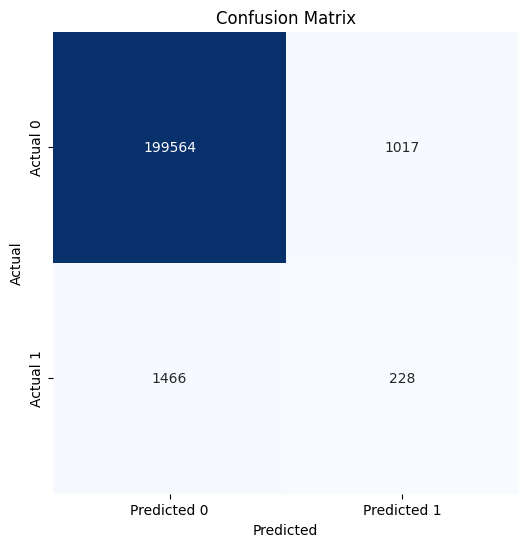

In [55]:
res = []
datasets = ['comp']
for ds in datasets:
    data_total = pd.read_csv('data/w_removal_%s' % ds, sep=" ", header=None)
    print('Analyzing %s Dataset' % ds)
    data_total.columns = ["n1", "n2", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "l"]
    data_total.dropna(subset=['n1', 'n2'], inplace=True)

    # taking the unique values of the nodes and saving the indices
    nodes = np.unique(data_total[['n1', 'n2']].values)
    node_index = {node: idx for idx, node in enumerate(nodes)}

    # creating an adj matrix (numpy) of size nodes*nodes filled with 0s
    adj_matrix = np.zeros((len(nodes), len(nodes)), dtype=float)

    # populating the adj matrix using the nodes and the labels
    for _, row in data_total.iterrows():
        i, j = node_index[row['n1']], node_index[row['n2']]
        adj_matrix[i, j] = row['l']
        adj_matrix[j, i] = row['l']

    # turning the numpy matrix into a pandas df
    adj_df = pd.DataFrame(adj_matrix, index=nodes, columns=nodes)

    labels = data_total["l"]
    ones_label = np.where(labels == 1)

    # Create graph using node indices
    src = data_total["n1"].map(node_index).astype(int)
    dst = data_total["n2"].map(node_index).astype(int)

    src = torch.tensor(src.values[ones_label], dtype=torch.int64)
    dst = torch.tensor(dst.values[ones_label], dtype=torch.int64)

    """g = dgl.graph((src, dst))

    # Initialize node features as an identity matrix
    inputs = torch.eye(g.number_of_nodes()).to(device)"""

    comp_g = graph((torch.cat([src, dst]), torch.cat([dst, src])))
    comp_g = comp_g
    inputs_comp = comp_g.adj().to_dense()   
    


    """
    Generate all of the possible edges and remove 90% of them from the training set
    """
    # K-fold cross validation
    k = 10
    auc_all = np.zeros((k,))
    acc_all = np.zeros((k,))

    for _ in range(k):
        print('Fold %d of %d' % (_+1, k))

    
        upper_tri_idx = np.triu_indices_from(adj_df, k=1)
        pairs = [(i, j) for i, j in zip(*upper_tri_idx)]
        pairs += [(j, i) for i, j in pairs]  # Add (j, i) for each (i, j)
        
        np.random.shuffle(pairs)
        possible_edges = np.array(pairs)
        
        test_size = int(len(possible_edges) * 0.25) # How much of the possible edges we will be removing
        train_size = len(possible_edges) - test_size
        
        test_edges = possible_edges[:test_size]
        train_edges = possible_edges[test_size:]
    
        test_pos_u = []
        test_pos_v = []
        test_neg_u = []
        test_neg_v = []
    
        for u, v in test_edges:
            if comp_g.has_edges_between(u, v):
                test_pos_u.append(u)
                test_pos_v.append(v)
            else:
                test_neg_u.append(u)
                test_neg_v.append(v)
    
        train_pos_u = []
        train_pos_v = []
        train_neg_u = []
        train_neg_v = []
        
        for u, v in train_edges:
            if comp_g.has_edges_between(u, v):
                train_pos_u.append(u)
                train_pos_v.append(v)
            else:
                train_neg_u.append(u)
                train_neg_v.append(v)
                
        #train_u, train_v = train_edges[:, 0], train_edges[:, 1]
    
        # Create subgraphs for training and testing
        train_pos_g_comp = dgl.graph((torch.tensor(train_pos_u), torch.tensor(train_pos_v)), num_nodes=comp_g.number_of_nodes())
        train_neg_g_comp = dgl.graph((torch.tensor(train_neg_u), torch.tensor(train_neg_v)), num_nodes=comp_g.number_of_nodes())
    
        test_pos_g_comp = dgl.graph((torch.tensor(test_pos_u), torch.tensor(test_pos_v)), num_nodes=comp_g.number_of_nodes())
        test_neg_g_comp = dgl.graph((torch.tensor(test_neg_u), torch.tensor(test_neg_v)), num_nodes=comp_g.number_of_nodes())
    
        
        model = GraphSAGE(comp_g.number_of_nodes(), 16)
        pred = DotPredictor()
        
        optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.001)
        
        for e in range(501):
            h = model(train_pos_g_comp, inputs_comp)
            pos_score = pred(train_pos_g_comp, h)
            neg_score = pred(train_neg_g_comp, h)
            loss = compute_loss(pos_score, neg_score)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            if e % 100 == 0:
                print('In epoch {}, loss: {}'.format(e, loss.item()))
        
        with torch.no_grad():
            h = model(train_pos_g_comp, inputs_comp)
            pos_score = pred(test_pos_g_comp, h)
            neg_score = pred(test_neg_g_comp, h)
            auc = compute_auc(pos_score, neg_score)
            acc = compute_acc(pos_score, neg_score)
            print('AUC', auc)
            print('ACC', acc)
    
            auc_all[_] = compute_auc(pos_score, neg_score)
            acc_all[_] = compute_acc(pos_score, neg_score)
    
            res.append({
            'Dataset': ds,
            'Test_Size': test_size,
            'AUC': auc,
            'ACC': acc
        })

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': e
}, 'model_comp_25p.pth')

dgl.save_graphs("graphs_comp_25p.bin", [train_pos_g_comp, train_neg_g_comp, test_pos_g_comp, test_neg_g_comp, comp_g])


res.append({
    'AUC mean': str(np.mean(auc_all)),
    'AUC std': str(np.std(auc_all)),
    'ACC mean': str(np.mean(acc_all)),
    'ACC std': str(np.std(acc_all))
})
# Convert results to DataFrame
results_df = pd.DataFrame(res)

# Save to CSV
results_df.to_csv('Comp_25p.csv', index=False)
        
# print results
print('Results for %s dataset' % ds)
print('AUC mean: ' + str(np.mean(auc_all)))
print('AUC std: ' + str(np.std(auc_all)))

print('ACC mean: ' + str(np.mean(acc_all)))
print('ACC std: ' + str(np.std(acc_all)))

# Generate true labels
y_true_pos = [1] * len(pos_score)  # True labels for positive edges (1)
y_true_neg = [0] * len(neg_score)  # True labels for negative edges (0)

y_true = y_true_pos + y_true_neg  # Combine true labels for the test set

# Generate predicted labels by thresholding the scores
y_pred_pos = (pos_score >= 0.5).int().tolist()  # Predicted labels for positive edges
y_pred_neg = (neg_score >= 0.5).int().tolist()  # Predicted labels for negative edges

y_pred = y_pred_pos + y_pred_neg  # Combine predicted labels for the test set

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix using seaborn with integer formatting
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_comp25p.png', dpi=200, bbox_inches='tight')
plt.show()

np.save('cm_comp_25.npy', cm)

In [38]:
G = nx.from_numpy_array(adj_matrix)
nx.algebraic_connectivity(G)

0.6659564473416898

In [9]:
print(f'Number of nodes and edges in train_pos_g_comp: {len(train_pos_g_comp.nodes())} , {len(train_pos_g_comp.edges()[0])}')
print(f'Number of nodes and edges in train_neg_g_comp: {len(train_neg_g_comp.nodes())} , {len(train_neg_g_comp.edges()[0])}')
print(f'Number of nodes and edges in test_pos_g_comp: {len(test_pos_g_comp.nodes())} , {len(test_pos_g_comp.edges()[0])}')
print(f'Number of nodes and edges in test_neg_g_comp: {len(test_neg_g_comp.nodes())} , {len(test_neg_g_comp.edges()[0])}')

Number of nodes and edges in train_pos_g_comp: 900 , 6466
Number of nodes and edges in train_neg_g_comp: 900 , 762179
Number of nodes and edges in test_pos_g_comp: 900 , 370
Number of nodes and edges in test_neg_g_comp: 900 , 40085


## ML Dataset

Analyzing ml Dataset
Fold 1 of 10
In epoch 0, loss: 4.464259624481201
In epoch 100, loss: 0.7051791548728943
In epoch 200, loss: 0.69587242603302
In epoch 300, loss: 0.694146990776062
In epoch 400, loss: 0.6935327053070068
In epoch 500, loss: 0.6932535171508789
AUC 0.6970764971300337
ACC 0.9925003752030347
Fold 2 of 10
In epoch 0, loss: 2.936553955078125
In epoch 100, loss: 0.6983568072319031
In epoch 200, loss: 0.6941931843757629
In epoch 300, loss: 0.6935017108917236
In epoch 400, loss: 0.69306480884552
In epoch 500, loss: 0.6924911141395569
AUC 0.6285839573669585
ACC 0.9927280846310184
Fold 3 of 10
In epoch 0, loss: 3.899531364440918
In epoch 100, loss: 0.7179315686225891
In epoch 200, loss: 0.6972572803497314
In epoch 300, loss: 0.6933684945106506
In epoch 400, loss: 0.6913366317749023
In epoch 500, loss: 0.6893453001976013
AUC 0.6834329888197267
ACC 0.9919813751431501
Fold 4 of 10
In epoch 0, loss: 8.09299373626709
In epoch 100, loss: 0.7241731286048889
In epoch 200, loss: 0.69790

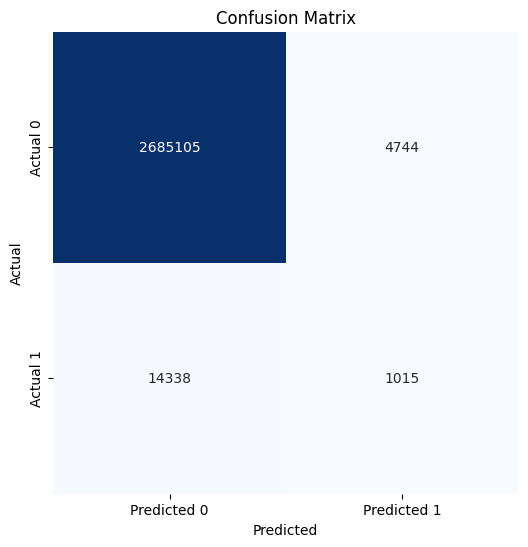

In [3]:
res = []
datasets = ['ml']
for ds in datasets:
    data_total = pd.read_csv('data/w_removal_%s' % ds, sep=" ", header=None)
    print('Analyzing %s Dataset' % ds)
    data_total.columns = ["n1", "n2", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "l"]
    data_total.dropna(subset=['n1', 'n2'], inplace=True)

    # taking the unique values of the nodes and saving the indices
    nodes = np.unique(data_total[['n1', 'n2']].values)
    node_index = {node: idx for idx, node in enumerate(nodes)}

    # creating an adj matrix (numpy) of size nodes*nodes filled with 0s
    adj_matrix = np.zeros((len(nodes), len(nodes)), dtype=float)

    # populating the adj matrix using the nodes and the labels
    for _, row in data_total.iterrows():
        i, j = node_index[row['n1']], node_index[row['n2']]
        adj_matrix[i, j] = row['l']
        adj_matrix[j, i] = row['l']

    # turning the numpy matrix into a pandas df
    adj_df = pd.DataFrame(adj_matrix, index=nodes, columns=nodes)

    labels = data_total["l"]
    ones_label = np.where(labels == 1)

    # Create graph using node indices
    src = data_total["n1"].map(node_index).astype(int)
    dst = data_total["n2"].map(node_index).astype(int)

    src = torch.tensor(src.values[ones_label], dtype=torch.int64)
    dst = torch.tensor(dst.values[ones_label], dtype=torch.int64)

    """g = dgl.graph((src, dst))

    # Initialize node features as an identity matrix
    inputs = torch.eye(g.number_of_nodes()).to(device)"""

    ml_g = graph((torch.cat([src, dst]), torch.cat([dst, src])))
    ml_g = ml_g
    inputs_ml = ml_g.adj().to_dense() 
    


    """
    Generate all of the possible edges and remove 90% of them from the training set
    """
    # K-fold cross validation
    k = 10
    auc_all = np.zeros((k,))
    acc_all = np.zeros((k,))

    for _ in range(k):
        print('Fold %d of %d' % (_+1, k))

    
        upper_tri_idx = np.triu_indices_from(adj_df, k=1)
        pairs = [(i, j) for i, j in zip(*upper_tri_idx)]
        pairs += [(j, i) for i, j in pairs]  # Add (j, i) for each (i, j)
        
        np.random.shuffle(pairs)
        possible_edges = np.array(pairs)
        
        test_size = int(len(possible_edges) * 0.25) # How much of the possible edges we will be removing
        train_size = len(possible_edges) - test_size
        
        test_edges = possible_edges[:test_size]
        train_edges = possible_edges[test_size:]
    
        
        test_pos_u = []
        test_pos_v = []
        test_neg_u = []
        test_neg_v = []
    
        for u, v in test_edges:
            if ml_g.has_edges_between(u, v):
                test_pos_u.append(u)
                test_pos_v.append(v)
            else:
                test_neg_u.append(u)
                test_neg_v.append(v)
    
        train_pos_u = []
        train_pos_v = []
        train_neg_u = []
        train_neg_v = []
        
        for u, v in train_edges:
            if ml_g.has_edges_between(u, v):
                train_pos_u.append(u)
                train_pos_v.append(v)
            else:
                train_neg_u.append(u)
                train_neg_v.append(v)
        
    
    
            
                
        #train_u, train_v = train_edges[:, 0], train_edges[:, 1]
    
        # Create subgraphs for training and testing
        train_pos_g_ml = dgl.graph((torch.tensor(train_pos_u), torch.tensor(train_pos_v)), num_nodes=ml_g.number_of_nodes())
        train_neg_g_ml = dgl.graph((torch.tensor(train_neg_u), torch.tensor(train_neg_v)), num_nodes=ml_g.number_of_nodes())
    
        test_pos_g_ml = dgl.graph((torch.tensor(test_pos_u), torch.tensor(test_pos_v)), num_nodes=ml_g.number_of_nodes())
        test_neg_g_ml = dgl.graph((torch.tensor(test_neg_u), torch.tensor(test_neg_v)), num_nodes=ml_g.number_of_nodes())
    
        
        model = GraphSAGE(ml_g.number_of_nodes(), 16)
        pred = DotPredictor()
        
        optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.001)
        
        for e in range(501):
            h = model(train_pos_g_ml, inputs_ml)
            pos_score = pred(train_pos_g_ml, h)
            neg_score = pred(train_neg_g_ml, h)
            loss = compute_loss(pos_score, neg_score)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            if e % 100 == 0:
                print('In epoch {}, loss: {}'.format(e, loss.item()))
        
        with torch.no_grad():
            h = model(train_pos_g_ml, inputs_ml)
            pos_score = pred(test_pos_g_ml, h)
            neg_score = pred(test_neg_g_ml, h)
            auc = compute_auc(pos_score, neg_score)
            acc = compute_acc(pos_score, neg_score)
            print('AUC', auc)
            print('ACC', acc)
    
            auc_all[_] = compute_auc(pos_score, neg_score)
            acc_all[_] = compute_acc(pos_score, neg_score)
    
            res.append({
            'Dataset': ds,
            'Test_Size': test_size,
            'AUC': auc,
            'ACC': acc
        })

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': e
}, 'model_ml_25p.pth')

dgl.save_graphs("graphs_ml_25p.bin", [train_pos_g_ml, train_neg_g_ml, test_pos_g_ml, test_neg_g_ml, ml_g])

res.append({
    'AUC mean': str(np.mean(auc_all)),
    'AUC std': str(np.std(auc_all)),
    'ACC mean': str(np.mean(acc_all)),
    'ACC std': str(np.std(acc_all))
})
# Convert results to DataFrame
results_df = pd.DataFrame(res)

# Save to CSV
results_df.to_csv('ML_25p.csv', index=False)
        
# print results
print('Results for %s dataset' % ds)
print('AUC mean: ' + str(np.mean(auc_all)))
print('AUC std: ' + str(np.std(auc_all)))

print('ACC mean: ' + str(np.mean(acc_all)))
print('ACC std: ' + str(np.std(acc_all)))

# Generate true labels
y_true_pos = [1] * len(pos_score)  # True labels for positive edges (1)
y_true_neg = [0] * len(neg_score)  # True labels for negative edges (0)

y_true = y_true_pos + y_true_neg  # Combine true labels for the test set

# Generate predicted labels by thresholding the scores
y_pred_pos = (pos_score >= 0.5).int().tolist()  # Predicted labels for positive edges
y_pred_neg = (neg_score >= 0.5).int().tolist()  # Predicted labels for negative edges

y_pred = y_pred_pos + y_pred_neg  # Combine predicted labels for the test set

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix using seaborn with integer formatting
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_ml_25p.png', dpi=200, bbox_inches='tight')
plt.show()

np.save('cm_ml_25.npy', cm)

In [51]:
G = nx.from_numpy_array(adj_matrix)
nx.algebraic_connectivity(G)

0.9062134926786997

In [11]:
print(f'Number of nodes and edges in train_pos_g_ml: {len(train_pos_g_ml.nodes())} , {len(train_pos_g_ml.edges()[0])}')
print(f'Number of nodes and edges in train_neg_g_ml: {len(train_neg_g_ml.nodes())} , {len(train_neg_g_ml.edges()[0])}')
print(f'Number of nodes and edges in test_pos_g_ml: {len(test_pos_g_ml.nodes())} , {len(test_pos_g_ml.edges()[0])}')
print(f'Number of nodes and edges in test_neg_g_ml: {len(test_neg_g_ml.nodes())} , {len(test_neg_g_ml.edges()[0])}')

Number of nodes and edges in train_pos_g_ml: 3290 , 58130
Number of nodes and edges in train_neg_g_ml: 3290 , 10221640
Number of nodes and edges in test_pos_g_ml: 3290 , 3090
Number of nodes and edges in test_neg_g_ml: 3290 , 537950


## Shakespeare Dataset

Analyzing virtualshakespeare Dataset
Fold 1 of 10
In epoch 0, loss: 6.001633167266846
In epoch 100, loss: 0.7041645050048828
In epoch 200, loss: 0.6949606537818909
In epoch 300, loss: 0.6930081248283386
In epoch 400, loss: 0.691839337348938
In epoch 500, loss: 0.6909031867980957
AUC 0.679094285439368
ACC 0.9755097759869945
Fold 2 of 10
In epoch 0, loss: 7.897585391998291
In epoch 100, loss: 0.7057585716247559
In epoch 200, loss: 0.6940833330154419
In epoch 300, loss: 0.6919072270393372
In epoch 400, loss: 0.6902981996536255
In epoch 500, loss: 0.6890586614608765
AUC 0.6514704397095159
ACC 0.9742599180163093
Fold 3 of 10
In epoch 0, loss: 5.517745018005371
In epoch 100, loss: 0.7071219682693481
In epoch 200, loss: 0.6939898729324341
In epoch 300, loss: 0.6918753385543823
In epoch 400, loss: 0.6905013918876648
In epoch 500, loss: 0.6892892718315125
AUC 0.6642650591393482
ACC 0.9772665693583771
Fold 4 of 10
In epoch 0, loss: 9.880390167236328
In epoch 100, loss: 0.7352311611175537
In epoc

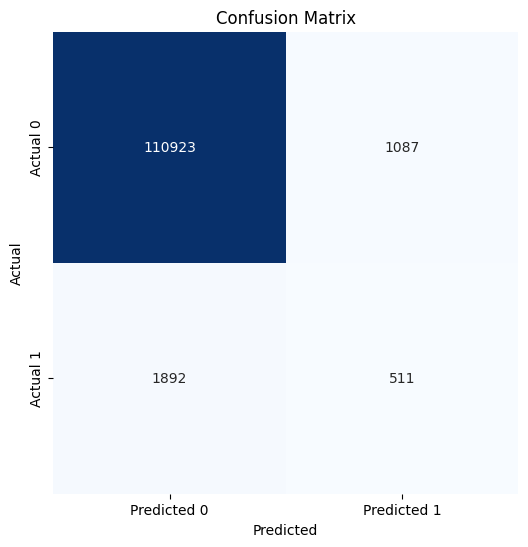

In [4]:
res = []
datasets = ['virtualshakespeare']
for ds in datasets:
    data_total = pd.read_csv('data/w_removal_%s' % ds, sep=" ", header=None)
    print('Analyzing %s Dataset' % ds)
    data_total.columns = ["n1", "n2", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "l"]
    data_total.dropna(subset=['n1', 'n2'], inplace=True)

    # taking the unique values of the nodes and saving the indices
    nodes = np.unique(data_total[['n1', 'n2']].values)
    node_index = {node: idx for idx, node in enumerate(nodes)}

    # creating an adj matrix (numpy) of size nodes*nodes filled with 0s
    adj_matrix = np.zeros((len(nodes), len(nodes)), dtype=float)

    # populating the adj matrix using the nodes and the labels
    for _, row in data_total.iterrows():
        i, j = node_index[row['n1']], node_index[row['n2']]
        adj_matrix[i, j] = row['l']
        adj_matrix[j, i] = row['l']

    # turning the numpy matrix into a pandas df
    adj_df = pd.DataFrame(adj_matrix, index=nodes, columns=nodes)

    labels = data_total["l"]
    ones_label = np.where(labels == 1)

    # Create graph using node indices
    src = data_total["n1"].map(node_index).astype(int)
    dst = data_total["n2"].map(node_index).astype(int)

    src = torch.tensor(src.values[ones_label], dtype=torch.int64)
    dst = torch.tensor(dst.values[ones_label], dtype=torch.int64)

    """g = dgl.graph((src, dst))

    # Initialize node features as an identity matrix
    inputs = torch.eye(g.number_of_nodes()).to(device)"""

    shake_g = graph((torch.cat([src, dst]), torch.cat([dst, src])))
    shake_g = shake_g
    inputs_shake = shake_g.adj().to_dense()
    


    """
    Generate all of the possible edges and remove 90% of them from the training set
    """
    # K-fold cross validation
    k = 10
    auc_all = np.zeros((k,))
    acc_all = np.zeros((k,))

    for _ in range(k):
        print('Fold %d of %d' % (_+1, k))

    
        upper_tri_idx = np.triu_indices_from(adj_df, k=1)
        pairs = [(i, j) for i, j in zip(*upper_tri_idx)]
        pairs += [(j, i) for i, j in pairs]  # Add (j, i) for each (i, j)
        
        np.random.shuffle(pairs)
        possible_edges = np.array(pairs)
        
        test_size = int(len(possible_edges) * 0.25) # How much of the possible edges we will be removing
        train_size = len(possible_edges) - test_size
        
        test_edges = possible_edges[:test_size]
        train_edges = possible_edges[test_size:]
    
        test_pos_u = []
        test_pos_v = []
        test_neg_u = []
        test_neg_v = []
    
        for u, v in test_edges:
            if shake_g.has_edges_between(u, v):
                test_pos_u.append(u)
                test_pos_v.append(v)
            else:
                test_neg_u.append(u)
                test_neg_v.append(v)
    
        train_pos_u = []
        train_pos_v = []
        train_neg_u = []
        train_neg_v = []
        
        for u, v in train_edges:
            if shake_g.has_edges_between(u, v):
                train_pos_u.append(u)
                train_pos_v.append(v)
            else:
                train_neg_u.append(u)
                train_neg_v.append(v)
                
        #train_u, train_v = train_edges[:, 0], train_edges[:, 1]
    
        # Create subgraphs for training and testing
        train_pos_g_shake = dgl.graph((torch.tensor(train_pos_u), torch.tensor(train_pos_v)), num_nodes=shake_g.number_of_nodes())
        train_neg_g_shake = dgl.graph((torch.tensor(train_neg_u), torch.tensor(train_neg_v)), num_nodes=shake_g.number_of_nodes())
    
        test_pos_g_shake = dgl.graph((torch.tensor(test_pos_u), torch.tensor(test_pos_v)), num_nodes=shake_g.number_of_nodes())
        test_neg_g_shake = dgl.graph((torch.tensor(test_neg_u), torch.tensor(test_neg_v)), num_nodes=shake_g.number_of_nodes())
    
    
        model = GraphSAGE(shake_g.number_of_nodes(), 16)
        pred = DotPredictor()
        
        optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.001)
        
        for e in range(501):
            h = model(train_pos_g_shake, inputs_shake)
            pos_score = pred(train_pos_g_shake, h)
            neg_score = pred(train_neg_g_shake, h)
            loss = compute_loss(pos_score, neg_score)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            if e % 100 == 0:
                print('In epoch {}, loss: {}'.format(e, loss.item()))
        
        with torch.no_grad():
            h = model(train_pos_g_shake, inputs_shake)
            pos_score = pred(test_pos_g_shake, h)
            neg_score = pred(test_neg_g_shake, h)
            auc = compute_auc(pos_score, neg_score)
            acc = compute_acc(pos_score, neg_score)
            print('AUC', auc)
            print('ACC', acc)
    
            auc_all[_] = compute_auc(pos_score, neg_score)
            acc_all[_] = compute_acc(pos_score, neg_score)
    
            res.append({
            'Dataset': ds,
            'Test_Size': test_size,
            'AUC': auc,
            'ACC': acc
        })
            
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': e
}, 'model_shake_25p.pth')

dgl.save_graphs("graphs_shake_25p.bin", [train_pos_g_shake, train_neg_g_shake, test_pos_g_shake, test_neg_g_shake, shake_g])

res.append({
    'AUC mean': str(np.mean(auc_all)),
    'AUC std': str(np.std(auc_all)),
    'ACC mean': str(np.mean(acc_all)),
    'ACC std': str(np.std(acc_all))
})
# Convert results to DataFrame
results_df = pd.DataFrame(res)

# Save to CSV
results_df.to_csv('Shake_25p.csv', index=False)
        
# print results
print('Results for %s dataset' % ds)
print('AUC mean: ' + str(np.mean(auc_all)))
print('AUC std: ' + str(np.std(auc_all)))

print('ACC mean: ' + str(np.mean(acc_all)))
print('ACC std: ' + str(np.std(acc_all)))

# Generate true labels
y_true_pos = [1] * len(pos_score)  # True labels for positive edges (1)
y_true_neg = [0] * len(neg_score)  # True labels for negative edges (0)

y_true = y_true_pos + y_true_neg  # Combine true labels for the test set

# Generate predicted labels by thresholding the scores
y_pred_pos = (pos_score >= 0.5).int().tolist()  # Predicted labels for positive edges
y_pred_neg = (neg_score >= 0.5).int().tolist()  # Predicted labels for negative edges

y_pred = y_pred_pos + y_pred_neg  # Combine predicted labels for the test set

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix using seaborn with integer formatting
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_shake25p.png', dpi=200, bbox_inches='tight')
plt.show()

np.save('cm_shake_25.npy', cm)

In [13]:
print(f'Number of nodes and edges in train_pos_g_shake: {len(train_pos_g_shake.nodes())} , {len(train_pos_g_shake.edges()[0])}')
print(f'Number of nodes and edges in train_neg_g_shake: {len(train_neg_g_shake.nodes())} , {len(train_neg_g_shake.edges()[0])}')
print(f'Number of nodes and edges in test_pos_g_shake: {len(test_pos_g_shake.nodes())} , {len(test_pos_g_shake.edges()[0])}')
print(f'Number of nodes and edges in test_neg_g_shake: {len(test_neg_g_shake.nodes())} , {len(test_neg_g_shake.edges()[0])}')

Number of nodes and edges in train_pos_g_shake: 677 , 8904
Number of nodes and edges in train_neg_g_shake: 677 , 425866
Number of nodes and edges in test_pos_g_shake: 677 , 500
Number of nodes and edges in test_neg_g_shake: 677 , 22382


In [4]:
import networkx as nx

def combineGraphs(g1, g2):
    # Convert DGL graphs to NetworkX graphs
    nx_g1 = g1.to_networkx()
    nx_g2 = g2.to_networkx()
    
    # Relabel nodes in NetworkX graphs
    # Offset for g2
    offset = g1.num_nodes()
    mapping_g2 = {i: i + offset for i in range(g2.num_nodes())}
    nx_g2 = nx.relabel_nodes(nx_g2, mapping_g2)
    
    # Convert back to DGL graphs
    g1_relabelled = dgl.from_networkx(nx_g1)
    g2_relabelled = dgl.from_networkx(nx_g2)
    
    # Combine the relabeled DGL graphs
    combined_g = dgl.batch([g1_relabelled, g2_relabelled])

    return combined_g

In [21]:
train_pos_g_combined = combineGraphs(train_pos_g_shake, train_pos_g_comp)
train_neg_g_combined = combineGraphs(train_neg_g_shake, train_neg_g_comp)
test_pos_g_combined = combineGraphs(test_pos_g_shake, test_pos_g_comp)
test_neg_g_combined = combineGraphs(test_neg_g_shake, test_neg_g_comp)
g = combineGraphs(shake_g, comp_g)

In [22]:
train_pos_g_combined = combineGraphs(train_pos_g_combined, train_pos_g_algo)
train_neg_g_combined = combineGraphs(train_neg_g_combined, train_neg_g_algo)
test_pos_g_combined = combineGraphs(test_pos_g_combined, test_pos_g_algo)
test_neg_g_combined = combineGraphs(test_neg_g_combined, test_neg_g_algo)
g = combineGraphs(g, algo_g)

In [23]:
train_pos_g_combined = combineGraphs(train_pos_g_combined, train_pos_g_ml)
train_neg_g_combined = combineGraphs(train_neg_g_combined, train_neg_g_ml)
test_pos_g_combined = combineGraphs(test_pos_g_combined, test_pos_g_ml)
test_neg_g_combined = combineGraphs(test_neg_g_combined, test_neg_g_ml)
g = combineGraphs(g, ml_g)

In [24]:
inputs = g.adj().to_dense()

In [82]:
print(f'Number of nodes and edges in train_pos_g_combined: {len(train_pos_g_combined.nodes())} , {len(train_pos_g_combined.edges()[0])}')
print(f'Number of nodes and edges in train_neg_g_combined: {len(train_neg_g_combined.nodes())} , {len(train_neg_g_combined.edges()[0])}')
print(f'Number of nodes and edges in test_pos_g_combined: {len(test_pos_g_combined.nodes())} , {len(test_pos_g_combined.edges()[0])}')
print(f'Number of nodes and edges in test_neg_g_combined: {len(test_neg_g_combined.nodes())} , {len(test_neg_g_combined.edges()[0])}')
print(f'Number of nodes and edges in g: {len(g.nodes())} , {len(g.edges()[0])}') 

Number of nodes and edges in train_pos_g_combined: 6032 , 81911
Number of nodes and edges in train_neg_g_combined: 6032 , 12017349
Number of nodes and edges in test_pos_g_combined: 6032 , 9095
Number of nodes and edges in test_neg_g_combined: 6032 , 1335267
Number of nodes and edges in g: 6032 , 91006


In [25]:
k = 10

auc_all_algo = np.zeros((k,))
acc_all_algo = np.zeros((k,))

auc_all_comp = np.zeros((k,))
acc_all_comp = np.zeros((k,))

auc_all_ml = np.zeros((k,))
acc_all_ml = np.zeros((k,))

auc_all_shake = np.zeros((k,))
acc_all_shake = np.zeros((k,))

res = []
for _ in range(k):
    print('Fold %d of %d' % (_+1, k))
    
    model = GraphSAGE(g.number_of_nodes(), 16)
    pred = DotPredictor()
    
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.001)
    
    for e in range(501):
        h = model(train_pos_g_combined, inputs)
        pos_score = pred(train_pos_g_combined, h)
        neg_score = pred(train_neg_g_combined, h)
        loss = compute_loss(pos_score, neg_score)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if e % 100 == 0:
            print('In epoch {}, loss: {}'.format(e, loss.item()))
    
    with torch.no_grad():
        h = model(train_pos_g_combined, inputs)
        pos_score = pred(test_pos_g_combined, h)
        neg_score = pred(test_neg_g_combined, h)
        #print('AUC', compute_auc(pos_score, neg_score))
        #print('ACC', compute_acc(pos_score, neg_score))
    
    
    nodes_dataset_1 = set(range(677))  # Node IDs from the first dataset
    nodes_dataset_2 = set(range(677, 1577))  # Node IDs from the second dataset
    nodes_dataset_3 = set(range(1577, 2742))
    nodes_dataset_4 = set(range(2742, 6032))
    
    
    pos_edges = list(zip(test_pos_g_combined.edges()[0].numpy(), test_pos_g_combined.edges()[1].numpy()))
    neg_edges = list(zip(test_neg_g_combined.edges()[0].numpy(), test_neg_g_combined.edges()[1].numpy()))
    
    pos_score_1, pos_score_2, pos_score_3, pos_score_4 = [], [], [], []
    neg_score_1, neg_score_2, neg_score_3, neg_score_4 = [], [], [], []
    
    
    for i, edge in enumerate(pos_edges):
        if edge[0] in nodes_dataset_1 and edge[1] in nodes_dataset_1:
            pos_score_1.append(pos_score[i])
        elif edge[0] in nodes_dataset_2 and edge[1] in nodes_dataset_2:
            pos_score_2.append(pos_score[i])
        elif edge[0] in nodes_dataset_3 and edge[1] in nodes_dataset_3:
            pos_score_3.append(pos_score[i])
        else:
            pos_score_4.append(pos_score[i])
    
    for i, edge in enumerate(neg_edges):
        if edge[0] in nodes_dataset_1 and edge[1] in nodes_dataset_1:
            neg_score_1.append(neg_score[i])
        elif edge[0] in nodes_dataset_2 and edge[1] in nodes_dataset_2:
            neg_score_2.append(neg_score[i])
        elif edge[0] in nodes_dataset_3 and edge[1] in nodes_dataset_3:
            neg_score_3.append(neg_score[i])
        else:
            neg_score_4.append(neg_score[i])
    
    
    pos_score_1 = torch.tensor(pos_score_1)
    pos_score_2 = torch.tensor(pos_score_2)
    neg_score_1 = torch.tensor(neg_score_1)
    neg_score_2 = torch.tensor(neg_score_2)
    pos_score_3 = torch.tensor(pos_score_3)
    pos_score_4 = torch.tensor(pos_score_4)
    neg_score_3 = torch.tensor(neg_score_3)
    neg_score_4 = torch.tensor(neg_score_4)
    
    auc_1 = compute_auc(pos_score_1, neg_score_1)
    acc_1 = compute_acc(pos_score_1, neg_score_1)
    
    auc_2 = compute_auc(pos_score_2, neg_score_2)
    acc_2 = compute_acc(pos_score_2, neg_score_2)
    
    auc_3 = compute_auc(pos_score_3, neg_score_3)
    acc_3 = compute_acc(pos_score_3, neg_score_3)
    
    auc_4 = compute_auc(pos_score_4, neg_score_4)
    acc_4 = compute_acc(pos_score_4, neg_score_4)
    
    print('AUC for dataset 1:', auc_1)
    print('ACC for dataset 1:', acc_1)
    print('AUC for dataset 2:', auc_2)
    print('ACC for dataset 2:', acc_2)
    print('AUC for dataset 3:', auc_3)
    print('ACC for dataset 3:', acc_3)
    print('AUC for dataset 4:', auc_4)
    print('ACC for dataset 4:', acc_4)

    auc_all_algo[_] = auc_1
    acc_all_algo[_] = acc_1

    auc_all_comp[_] = auc_2
    acc_all_comp[_] = acc_2

    auc_all_ml[_] = auc_3
    acc_all_ml[_] = acc_3

    auc_all_shake[_] = auc_4
    acc_all_shake[_] = acc_4

    res.append({
        'AUC Shake': auc_1,
        'ACC Shake': acc_1,
        'AUC Comp': auc_2,
        'ACC Comp': acc_2,
        'AUC Algo': auc_3,
        'ACC Algo': acc_3,
        'AUC ML': auc_4,
        'ACC ML': acc_4,
    })

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': e
}, 'model_shake-comp-algo-ml_25p.pth')

print('AUC mean algo: ' + str(np.mean(auc_all_algo)))
print('AUC std algo: ' + str(np.std(auc_all_algo)))
print('ACC mean algo: ' + str(np.mean(acc_all_algo)))
print('ACC std algo: ' + str(np.std(acc_all_algo)))

print('AUC mean comp: ' + str(np.mean(auc_all_comp)))
print('AUC std comp: ' + str(np.std(auc_all_comp)))
print('ACC mean comp: ' + str(np.mean(acc_all_comp)))
print('ACC std comp: ' + str(np.std(acc_all_comp)))

print('AUC mean ml: ' + str(np.mean(auc_all_ml)))
print('AUC std ml: ' + str(np.std(auc_all_ml)))
print('ACC mean ml: ' + str(np.mean(acc_all_ml)))
print('ACC std ml: ' + str(np.std(acc_all_ml)))

#print('AUC mean shake: ' + str(np.mean(auc_all_shake)))
#print('AUC std shake: ' + str(np.std(auc_all_shake)))
#print('ACC mean shake: ' + str(np.mean(acc_all_shake)))
#print('ACC std shake: ' + str(np.std(acc_all_shake)))

res.append({
    'AUC mean shake': np.mean(auc_all_algo),
    'AUC std shake' : np.std(auc_all_algo),
    'ACC mean shake': np.mean(acc_all_algo),
    'ACC std shake' : np.std(acc_all_algo),
    'AUC mean comp': np.mean(auc_all_comp),
    'AUC std comp' : np.std(auc_all_comp),
    'ACC mean comp': np.mean(acc_all_comp),
    'ACC std comp' : np.std(acc_all_comp),
    'AUC mean algo': np.mean(auc_all_ml),
    'AUC std algo' : np.std(auc_all_ml),
    'ACC mean algo': np.mean(acc_all_ml),
    'ACC std algo' : np.std(acc_all_ml),
    'AUC mean ml': np.mean(auc_all_shake),
    'AUC std ml' : np.std(auc_all_shake),
    'ACC mean ml': np.mean(acc_all_shake),
    'ACC std ml' : np.std(acc_all_shake),

})

# Convert results to DataFrame
results_df = pd.DataFrame(res)

# Save to CSV
results_df.to_csv('Combined_25p.csv', index=False)

Fold 1 of 10
In epoch 0, loss: 1.2482246160507202
In epoch 100, loss: 0.6947258710861206
In epoch 200, loss: 0.6902198791503906
In epoch 300, loss: 0.6877045035362244
In epoch 400, loss: 0.6860408782958984
In epoch 500, loss: 0.6844637989997864
AUC for dataset 1: 0.7309675474475166
ACC for dataset 1: 0.9737442423500826
AUC for dataset 2: 0.724802331458518
ACC for dataset 2: 0.9914423433444568
AUC for dataset 3: 0.7777961261317953
ACC for dataset 3: 0.9853192336622273
AUC for dataset 4: 0.7051127806312433
ACC for dataset 4: 0.9922271978210869
Fold 2 of 10
In epoch 0, loss: 2.2489352226257324
In epoch 100, loss: 0.7073756456375122
In epoch 200, loss: 0.6919397115707397
In epoch 300, loss: 0.6903100609779358
In epoch 400, loss: 0.6895163059234619
In epoch 500, loss: 0.688839852809906
AUC for dataset 1: 0.7094002645935208
ACC for dataset 1: 0.9781755569734208
AUC for dataset 2: 0.7158652844301943
ACC for dataset 2: 0.9905623532319862
AUC for dataset 3: 0.7771512570721564
ACC for dataset 3:

In [65]:
import scipy.stats as stats
import pandas as pd
datasets = ['20p']
for ds in datasets:
    data = pd.read_csv('New_20_Percent/Shake_%s.csv' % ds)
    data_combined = pd.read_csv('New_20_Percent/Combined_%s.csv' % ds)
    
    auc_val  = data['AUC'].dropna().values
    auc_combined = data_combined['AUC Shake'].dropna().values
    t_stat, p_value = stats.ttest_ind(auc_val, auc_combined, alternative='less', equal_var=False)
    
    # Display the results
    print(f'T-statistic: {t_stat:.3f}')
    print(f'P-value for %s: {p_value:.3f}' % ds)
    
    alphas = [0.1, 0.01, 0.05]
    for alpha in alphas:    
        if p_value < alpha:
            print("For %s alpha, Reject the null hypothesis (H0). The combined model performs better." % alpha)
        else:
            print("For %s alpha, Fail to reject the null hypothesis (H0). No significant difference between the models." % alpha)


T-statistic: -0.124
P-value for 20p: 0.451
For 0.1 alpha, Fail to reject the null hypothesis (H0). No significant difference between the models.
For 0.01 alpha, Fail to reject the null hypothesis (H0). No significant difference between the models.
For 0.05 alpha, Fail to reject the null hypothesis (H0). No significant difference between the models.


In [6]:
graphs, _ = dgl.load_graphs("graphs_algo_25p.bin")

# Unpack each graph
train_pos_g_algo = graphs[0]
train_neg_g_algo = graphs[1]
test_pos_g_algo = graphs[2]
test_neg_g_algo = graphs[3]
algo_g = graphs[4]

graphs, _ = dgl.load_graphs("graphs_comp_25p.bin")


train_pos_g_comp = graphs[0]
train_neg_g_comp = graphs[1]
test_pos_g_comp = graphs[2]
test_neg_g_comp = graphs[3]
comp_g = graphs[4]

graphs, _ = dgl.load_graphs("graphs_ml_25p.bin")

train_pos_g_ml = graphs[0]
train_neg_g_ml = graphs[1]
test_pos_g_ml = graphs[2]
test_neg_g_ml = graphs[3]
ml_g = graphs[4]

graphs, _ = dgl.load_graphs("graphs_shake_25p.bin")

train_pos_g_shake = graphs[0]
train_neg_g_shake = graphs[1]
test_pos_g_shake = graphs[2]
test_neg_g_shake = graphs[3]
shake_g = graphs[4]

In [128]:
train_pos_g_combined = combineGraphs(train_pos_g_algo, train_pos_g_shake)
train_neg_g_combined = combineGraphs(train_neg_g_algo, train_neg_g_shake)
test_pos_g_combined = combineGraphs(test_pos_g_algo, test_pos_g_shake)
test_neg_g_combined = combineGraphs(test_neg_g_algo, test_neg_g_shake)
g = combineGraphs(algo_g, shake_g)

train_pos_g_combined = combineGraphs(train_pos_g_combined, train_pos_g_comp)
train_neg_g_combined = combineGraphs(train_neg_g_combined, train_neg_g_comp)
test_pos_g_combined = combineGraphs(test_pos_g_combined, test_pos_g_comp)
test_neg_g_combined = combineGraphs(test_neg_g_combined, test_neg_g_comp)
g = combineGraphs(g, comp_g)

train_pos_g_combined = combineGraphs(train_pos_g_combined, train_pos_g_ml)
train_neg_g_combined = combineGraphs(train_neg_g_combined, train_neg_g_ml)
test_pos_g_combined = combineGraphs(test_pos_g_combined, test_pos_g_ml)
test_neg_g_combined = combineGraphs(test_neg_g_combined, test_neg_g_ml)
g = combineGraphs(g, ml_g)

inputs = g.adj().to_dense()

In [130]:
k = 10

auc_all_algo = np.zeros((k,))
acc_all_algo = np.zeros((k,))

auc_all_comp = np.zeros((k,))
acc_all_comp = np.zeros((k,))

auc_all_ml = np.zeros((k,))
acc_all_ml = np.zeros((k,))

auc_all_shake = np.zeros((k,))
acc_all_shake = np.zeros((k,))

res = []
for _ in range(k):
    print('Fold %d of %d' % (_+1, k))
    
    model = GraphSAGE(g.number_of_nodes(), 16)
    pred = DotPredictor()
    
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.001)
    
    for e in range(501):
        h = model(train_pos_g_combined, inputs)
        pos_score = pred(train_pos_g_combined, h)
        neg_score = pred(train_neg_g_combined, h)
        loss = compute_loss(pos_score, neg_score)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if e % 100 == 0:
            print('In epoch {}, loss: {}'.format(e, loss.item()))
    
    with torch.no_grad():
        h = model(train_pos_g_combined, inputs)
        pos_score = pred(test_pos_g_combined, h)
        neg_score = pred(test_neg_g_combined, h)
        #print('AUC', compute_auc(pos_score, neg_score))
        #print('ACC', compute_acc(pos_score, neg_score))
    
    
    nodes_dataset_1 = set(range(1165))  # Node IDs from the first dataset
    nodes_dataset_2 = set(range(1165, 1842))  # Node IDs from the second dataset
    nodes_dataset_3 = set(range(1842, 2742))
    nodes_dataset_4 = set(range(2742, 6032))
    
    
    pos_edges = list(zip(test_pos_g_combined.edges()[0].numpy(), test_pos_g_combined.edges()[1].numpy()))
    neg_edges = list(zip(test_neg_g_combined.edges()[0].numpy(), test_neg_g_combined.edges()[1].numpy()))
    
    pos_score_1, pos_score_2, pos_score_3, pos_score_4 = [], [], [], []
    neg_score_1, neg_score_2, neg_score_3, neg_score_4 = [], [], [], []
    
    
    for i, edge in enumerate(pos_edges):
        if edge[0] in nodes_dataset_1 and edge[1] in nodes_dataset_1:
            pos_score_1.append(pos_score[i])
        elif edge[0] in nodes_dataset_2 and edge[1] in nodes_dataset_2:
            pos_score_2.append(pos_score[i])
        elif edge[0] in nodes_dataset_3 and edge[1] in nodes_dataset_3:
            pos_score_3.append(pos_score[i])
        else:
            pos_score_4.append(pos_score[i])
        
    
    for i, edge in enumerate(neg_edges):
        if edge[0] in nodes_dataset_1 and edge[1] in nodes_dataset_1:
            neg_score_1.append(neg_score[i])
        elif edge[0] in nodes_dataset_2 and edge[1] in nodes_dataset_2:
            neg_score_2.append(neg_score[i])
        elif edge[0] in nodes_dataset_3 and edge[1] in nodes_dataset_3:
            neg_score_3.append(neg_score[i])
        else:
            neg_score_4.append(neg_score[i])
    
    
    pos_score_1 = torch.tensor(pos_score_1)
    pos_score_2 = torch.tensor(pos_score_2)
    pos_score_3 = torch.tensor(pos_score_3)
    pos_score_4 = torch.tensor(pos_score_4)
    
    neg_score_1 = torch.tensor(neg_score_1)
    neg_score_2 = torch.tensor(neg_score_2)
    neg_score_3 = torch.tensor(neg_score_3)
    neg_score_4 = torch.tensor(neg_score_4)
    
    
    auc_1 = compute_auc(pos_score_1, neg_score_1)
    acc_1 = compute_acc(pos_score_1, neg_score_1)
    
    auc_2 = compute_auc(pos_score_2, neg_score_2)
    acc_2 = compute_acc(pos_score_2, neg_score_2)
    
    auc_3 = compute_auc(pos_score_3, neg_score_3)
    acc_3 = compute_acc(pos_score_3, neg_score_3)

    auc_4 = compute_auc(pos_score_4, neg_score_4)
    acc_4 = compute_acc(pos_score_4, neg_score_4)
    
    
    print('AUC for dataset 1:', auc_1)
    print('ACC for dataset 1:', acc_1)
    print('AUC for dataset 2:', auc_2)
    print('ACC for dataset 2:', acc_2)    
    print('AUC for dataset 3:', auc_3)
    print('ACC for dataset 3:', acc_3)
    

    auc_all_algo[_] = auc_1
    acc_all_algo[_] = acc_1

    auc_all_comp[_] = auc_2
    acc_all_comp[_] = acc_2

    auc_all_ml[_] = auc_3
    acc_all_ml[_] = acc_3

    auc_all_shake[_] = auc_4
    acc_all_shake[_] = acc_4
    

    res.append({
        'AUC Algo': auc_1,
        'ACC Algo': acc_1,
        'AUC Shake': auc_2,
        'ACC Shake': acc_2,
        'AUC Comp': auc_3,
        'ACC Comp': acc_3,
        'AUC ML': auc_4,
        'ACC ML': acc_4,
    })

print('AUC mean Comp: ' + str(np.mean(auc_all_algo)))
print('AUC std Comp: ' + str(np.std(auc_all_algo)))
print('ACC mean Comp: ' + str(np.mean(acc_all_algo)))
print('ACC std Comp: ' + str(np.std(acc_all_algo)))

print('AUC mean Algo: ' + str(np.mean(auc_all_comp)))
print('AUC std algo: ' + str(np.std(auc_all_comp)))
print('ACC mean algo: ' + str(np.mean(acc_all_comp)))
print('ACC std algo: ' + str(np.std(acc_all_comp)))

print('AUC mean Algo: ' + str(np.mean(auc_all_ml)))
print('AUC std Algo: ' + str(np.std(auc_all_ml)))
print('ACC mean Algo: ' + str(np.mean(acc_all_ml)))
print('ACC std Algo: ' + str(np.std(acc_all_ml)))



res.append({
    'AUC mean algo': np.mean(auc_all_algo),
    'AUC std algo' : np.std(auc_all_algo),
    'ACC mean algo': np.mean(acc_all_algo),
    'ACC std algo' : np.std(acc_all_algo),
    'AUC mean shake': np.mean(auc_all_comp),
    'AUC std shake' : np.std(auc_all_comp),
    'ACC mean shake': np.mean(acc_all_comp),
    'ACC std shake' : np.std(acc_all_comp),
    'AUC mean comp': np.mean(auc_all_ml),
    'AUC std comp' : np.std(auc_all_ml),
    'ACC mean comp': np.mean(acc_all_ml),
    'ACC std comp' : np.std(acc_all_ml),
    'AUC mean ml': np.mean(auc_all_shake),
    'AUC std ml' : np.std(auc_all_shake),
    'ACC mean ml': np.mean(acc_all_shake),
    'ACC std ml' : np.std(acc_all_shake),

})

# Convert results to DataFrame
results_df = pd.DataFrame(res)

# Save to CSV
results_df.to_csv('Combined_5p.csv', index=False)

Fold 1 of 10
In epoch 0, loss: 1.310952067375183
In epoch 100, loss: 0.6954591870307922
In epoch 200, loss: 0.6918495297431946
In epoch 300, loss: 0.6892198920249939
In epoch 400, loss: 0.6863341927528381
In epoch 500, loss: 0.684011697769165
AUC for dataset 1: 0.7716563053869703
ACC for dataset 1: 0.9840420040411191
AUC for dataset 2: 0.7179924206243075
ACC for dataset 2: 0.9787605978498383
AUC for dataset 3: 0.7595668511179241
ACC for dataset 3: 0.9895933753553331
Fold 2 of 10
In epoch 0, loss: 2.945615291595459
In epoch 100, loss: 0.6993197202682495
In epoch 200, loss: 0.6917494535446167
In epoch 300, loss: 0.6896839141845703
In epoch 400, loss: 0.6872678995132446
In epoch 500, loss: 0.683975338935852
AUC for dataset 1: 0.7498771416295182
ACC for dataset 1: 0.9844549651195375
AUC for dataset 2: 0.7104218007743348
ACC for dataset 2: 0.9786294904291583
AUC for dataset 3: 0.7285585057074251
ACC for dataset 3: 0.989395624768261
Fold 3 of 10
In epoch 0, loss: 1.8304091691970825
In epoch 

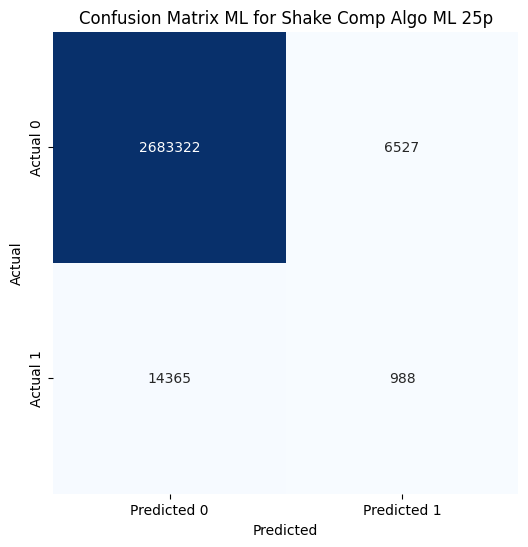

In [29]:
# Generate true labels
y_true_pos = [1] * len(pos_score_4)  # True labels for positive edges (1)
y_true_neg = [0] * len(neg_score_4)  # True labels for negative edges (0)

y_true = y_true_pos + y_true_neg  # Combine true labels for the test set

# Generate predicted labels by thresholding the scores
y_pred_pos = (pos_score_4 >= 0.5).int().tolist()  # Predicted labels for positive edges
y_pred_neg = (neg_score_4 >= 0.5).int().tolist()  # Predicted labels for negative edges

y_pred = y_pred_pos + y_pred_neg  # Combine predicted labels for the test set

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix using seaborn with integer formatting
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix ML for Shake Comp Algo ML 25p')
plt.savefig('cm_ml_shake-comp-algo_25p.png', dpi=200, bbox_inches='tight')
plt.show()

np.save('cm_ml_shake-comp-algo_25.npy', cm)

In [34]:
import os
import numpy as np

# Define the path to the folder containing the numpy files (confusion matrices)
npy_folder = 'New_25_Percent/CM_NPY'

# List all the numpy files in the folder
npy_files = [f for f in os.listdir(npy_folder) if f.endswith('.npy')]

# Loop through each numpy file and calculate the required metrics
for npy_file in npy_files:
    # Load the confusion matrix from the numpy file
    npy_path = os.path.join(npy_folder, npy_file)
    cm = np.load(npy_path)
    
    # Extract the values from the confusion matrix
    tn = cm[0, 0]  # Top-left: True Negative (TN)
    fp = cm[0, 1]  # Top-right: False Positive (FP)
    fn = cm[1, 0]  # Bottom-left: False Negative (FN)
    tp = cm[1, 1]  # Bottom-right: True Positive (TP)


    # Calculate the metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision: TP / (TP + FP)
    total_accuracy = tp / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0  # TP / (TP + FP + FN + TN)
    false_positive_rate = fp / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0  # FP / (TP + FP + FN + TN)

    # Print or store the results
    print(f"Metrics for {npy_file}:")
    print(f"Precision (TP / (TP + FP)): {precision}")
    print(f"Accuracy (TP / (TP + FP + FN + TN)): {total_accuracy}")
    print(f"False Positive Rate (FP / (TP + FP + FN + TN)): {false_positive_rate}")
    print("\n")


Metrics for cm_algo_25.npy:
Precision (TP / (TP + FP)): 0.31894484412470026
Accuracy (TP / (TP + FP + FN + TN)): 0.00353081722047697
False Positive Rate (FP / (TP + FP + FN + TN)): 0.007539489403123756


Metrics for cm_algo_shake-comp-algo_25.npy:
Precision (TP / (TP + FP)): 0.26476350405821436
Accuracy (TP / (TP + FP + FN + TN)): 0.0027904370013126264
False Positive Rate (FP / (TP + FP + FN + TN)): 0.007748919664321638


Metrics for cm_shake_algo-shake-ml_25.npy:
Precision (TP / (TP + FP)): 0.3374769797421731
Accuracy (TP / (TP + FP + FN + TN)): 0.0064066146329525495
False Positive Rate (FP / (TP + FP + FN + TN)): 0.012577242096614896


Metrics for cm_ml_algo-comp-ml_25.npy:
Precision (TP / (TP + FP)): 0.22554194156456173
Accuracy (TP / (TP + FP + FN + TN)): 0.000884591982410186
False Positive Rate (FP / (TP + FP + FN + TN)): 0.00303748111970936


Metrics for cm_shake_comp-shake_25.npy:
Precision (TP / (TP + FP)): 0.43847874720357943
Accuracy (TP / (TP + FP + FN + TN)): 0.001713092043

In [33]:
import os
import shutil

# Define the source directory (where the .png files are located)
source_dir = '.'  # Use '.' for current directory or specify another folder path

# Define the destination directory
destination_dir = 'New_25_Percent/Models'

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Move all .png files from source_dir to destination_dir
for filename in os.listdir(source_dir):
    if filename.endswith('.pth'):
        # Construct the full file path
        source_file = os.path.join(source_dir, filename)
        destination_file = os.path.join(destination_dir, filename)
        
        # Move the file
        shutil.move(source_file, destination_file)
        print(f"Moved {filename} to {destination_dir}")


Moved model_comp-shake_25p.pth to New_25_Percent/Models
Moved model_algo_25p.pth to New_25_Percent/Models
Moved model_algo-comp-ml_25p.pth to New_25_Percent/Models
Moved model_algo-shake_25p.pth to New_25_Percent/Models
Moved model_comp-ml_25p.pth to New_25_Percent/Models
Moved model_shake-comp-ml_25p.pth to New_25_Percent/Models
Moved model_shake-ml_25p.pth to New_25_Percent/Models
Moved model_algo-shake-ml_25p.pth to New_25_Percent/Models
Moved model_shake-comp-algo-ml_25p.pth to New_25_Percent/Models
Moved model_shake_25p.pth to New_25_Percent/Models
Moved model_shake-comp-algo_25p.pth to New_25_Percent/Models
Moved model_comp_25p.pth to New_25_Percent/Models
Moved model_ml_25p.pth to New_25_Percent/Models
Moved model_comp-algo_25p.pth to New_25_Percent/Models
Moved model_algo-ml_25p.pth to New_25_Percent/Models
